# Neighbourhood Walkability Analysis
**DATA2001: Practical Assignment**

* Emmanuel Isaac (SID: 440429216, unikey: eisa7257)
* Vishal Singh Uppal (SID: 440315067, unikey: vupp0002)


## Part 1: Data Integration and Database Generation

##### 1.1: Import Python libraries and define PostgreSQL Connection, Execution and Query

In [1]:
import psycopg2
import csv
import pprint
import numpy
import requests
import json
import shapefile


def pgconnect():
    YOUR_UNIKEY = 'eisa7257'
    YOUR_PW     = 'eisa7257'
    try: 
        conn = psycopg2.connect(host='localhost',
                                database='local',
                                user=YOUR_UNIKEY, 
                                 password=YOUR_PW)
        
        print('Connected.')
    except Exception as e:
        print("Unable to connect to the database.")
        print(e)
    return conn

def pgexec( conn, sqlcmd, args, msg, silent=True ):
   retval = False
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
               cur.execute(sqlcmd)
            else:
               cur.execute(sqlcmd, args)
            if silent == False: 
                print("Success: " + msg)
            retval = True
         except Exception as e:
            if silent == False: 
                print("db error: ")
                print(e)
   return retval

def pgquery( conn, sqlcmd, args, silent=False ):
   retval = False
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
                cur.execute(sqlcmd)
            else:
                cur.execute(sqlcmd, args)
            if silent == False:
                for record in cur:
                    print(record)
            retval = True
         except Exception as e:
            if silent == False:
                print("db read error: ")
                print(e)
   return retval

def pgquery( conn, sqlcmd, args=None, silent=False, returntype='tuple'):
    retval = None
    with conn:
        cursortype = None if returntype != 'dict' else psycopg2.extras.RealDictCursor
        with conn.cursor(cursor_factory=cursortype) as cur:
            try:
                if args is None:
                    cur.execute(sqlcmd)
                else:
                    cur.execute(sqlcmd, args)
                if (cur.description != None ):
                    retval = cur.fetchall()
                if silent != False:
                    print("success: " + silent)
            except Exception as e:
                if e.pgcode != None and not(silent):
                    print("db read error: ")
                print(e)
    return retval

##### 1.2: Import CSV data using DictReader

In [2]:
data_Neighbourhoods = list(csv.DictReader(open('neighbourhoods.csv')))
data_CensusStats = list(csv.DictReader(open('censusstats.csv')))
data_CarSharingPods = list(csv.DictReader(open('carsharingpods.csv')))
data_StatisticalAreas = list(csv.DictReader(open('statisticalareas.csv')))
data_BusinessStats = list(csv.DictReader(open('businessstats.csv')))

##### 1.3: Clean the data

In [3]:
DEFAULT_VALUE = numpy.nan

def clean(data, column_key, convert_function, default_value):
    special_values= {}
    for row in data:
        old_value = row[column_key]
        new_value = default_value
        try:
            if old_value in special_values.keys():
                new_value = special_values[old_value]
            else:
                new_value = convert_function(old_value)
        except (ValueError, TypeError):
            new_value = new_value
        row[column_key] = new_value

        
# Cleaning Neighbourhoods

print('Cleaning Neighbourhoods...')
clean(data_Neighbourhoods, 'area_id', str.strip, DEFAULT_VALUE)
clean(data_Neighbourhoods, 'area_name', str.strip, DEFAULT_VALUE)
clean(data_Neighbourhoods, 'land_area', float, DEFAULT_VALUE)
clean(data_Neighbourhoods, 'population', float, DEFAULT_VALUE)
clean(data_Neighbourhoods, 'number_of_dwellings', float, DEFAULT_VALUE)
clean(data_Neighbourhoods, 'number_of_businesses', float, DEFAULT_VALUE)
print('Cleaned Neighbourhoods.')


# Cleaning CensusStats

print('Cleaning CensusStats...')
clean(data_CensusStats, 'area_id', str.strip, DEFAULT_VALUE)
clean(data_CensusStats, 'median_annual_household_income', float, DEFAULT_VALUE)
clean(data_CensusStats, 'avg_monthly_rent', float, DEFAULT_VALUE)
print('Cleaned CensusStats.')

# Cleaning BusinessStats

print('Cleaning BusinessStats...')
clean(data_BusinessStats, 'num_businesses', float, DEFAULT_VALUE)
clean(data_BusinessStats, 'retail_trade', float, DEFAULT_VALUE)
clean(data_BusinessStats, 'accommodation_and_food_services', float, DEFAULT_VALUE)
clean(data_BusinessStats, 'health_care_and_social_assistance', float, DEFAULT_VALUE)
clean(data_BusinessStats, 'education_and_training', float, DEFAULT_VALUE)
clean(data_BusinessStats, 'arts_and_recreation_services', float, DEFAULT_VALUE)
print('Cleaned BusinessStats.')
print('All Done!')

Cleaning Neighbourhoods...
Cleaned Neighbourhoods.
Cleaning CensusStats...
Cleaned CensusStats.
Cleaning BusinessStats...
Cleaned BusinessStats.
All Done!


##### 1.4: Connect and login to the database

In [4]:
conn = pgconnect()
if conn is None or conn.closed:
    conn.close();

Connected.


##### 1.5: Reset all tables

In [5]:
pgexec (conn, "DROP TABLE IF EXISTS censusstats", None, "CensusStats has been reset.")
pgexec (conn, "DROP TABLE IF EXISTS carsharingpods", None, "CarSharingPods has been reset.")
pgexec (conn, "DROP TABLE IF EXISTS businessstats", None, "BusinessStats has been reset.")
pgexec (conn, "DROP TABLE IF EXISTS toiletmap", None, "ToiletMap has been reset.")
pgexec (conn, "DROP TABLE IF EXISTS walkability", None, "Walkability has been reset.")
pgexec (conn, "DROP TABLE IF EXISTS statisticalareas", None, "StatisticalAreas has been reset.")
pgexec (conn, "DROP TABLE IF EXISTS neighbourhoods", None, "Neighbourhoods has been reset.")

print('All Tables Reset!')

All Tables Reset!


##### 1.6: Establish schema

* **area_id** of the *StatisticalAreas* relation is a PRIMARY KEY. **area_id** of all other relations is a FOREIGN KEY referencing *area_id* in the *StatisticalAreas* relation.
* **pod_id** of the *CarSharingPods* relation is a PRIMARY KEY.

In [6]:
neighbourhoods_schema = """CREATE TABLE IF NOT EXISTS neighbourhoods (
                               area_id INTEGER PRIMARY KEY,
                               area_name VARCHAR(50),
                               land_area FLOAT,
                               population INTEGER,
                               number_of_dwellings INTEGER,
                               number_of_businesses INTEGER
                            )"""

statisticalareas_schema = """CREATE TABLE IF NOT EXISTS statisticalareas (
                               area_id INTEGER REFERENCES Neighbourhoods(area_id),
                               area_name VARCHAR(50),
                               parent_area_id INTEGER
                            )"""

businessstats_schema = """CREATE TABLE IF NOT EXISTS businessstats (
                               area_id INTEGER REFERENCES Neighbourhoods(area_id),
                               num_businesses INTEGER,
                               retail_trade INTEGER,
                               accommodation_and_food_services INTEGER,
                               health_care_and_social_assistance INTEGER,
                               education_and_training INTEGER,
                               arts_and_recreation_services INTEGER
                            )"""

censusstats_schema = """CREATE TABLE IF NOT EXISTS censusstats (
                               area_id INTEGER REFERENCES Neighbourhoods(area_id),
                               median_annual_household_income INTEGER,
                               avg_monthly_rent INTEGER
                            )"""

carsharingpods_schema = """CREATE TABLE IF NOT EXISTS carsharingpods (
                               pod_id INTEGER PRIMARY KEY,
                               name VARCHAR(100),
                               num_cars INTEGER,
                               latitude DOUBLE PRECISION,
                               longitude DOUBLE PRECISION,
                               description VARCHAR(5000)
                            )"""

pgexec (conn, neighbourhoods_schema, None, "Created Table Neighbourhoods.")
pgexec (conn, statisticalareas_schema, None, "Created Table StatisticalAreas.")
pgexec (conn, businessstats_schema, None, "Created Table BusinessStats.")
pgexec (conn, censusstats_schema, None, "Created Table CensusStats.")
pgexec (conn, carsharingpods_schema, None, "Created Table CarSharingPods.")

print('Schema Created!')

Schema Created!


##### 1.7: Load data into schema from CSVs

In [7]:
print('Loading into Neighbourhoods...')
print('...this may take a while...')

insert_stmt = """INSERT INTO neighbourhoods(area_id,
                                            area_name,
                                            land_area,
                                            population,
                                            number_of_dwellings,
                                            number_of_businesses) VALUES (%(area_id)s,
                                                                          %(area_name)s,
                                                                          %(land_area)s,
                                                                          %(population)s,
                                                                          %(number_of_dwellings)s,
                                                                          %(number_of_businesses)s)
                                                                          """
for row in data_Neighbourhoods:
    pgexec (conn, insert_stmt, row, 'row loaded')
    
print('Loaded!')
print('Loading into StatisticalAreas...')
print('...this may take a while...')
    
insert_stmt = """INSERT INTO StatisticalAreas(area_id,
                                              area_name,
                                              parent_area_id) VALUES (%(area_id)s,
                                                                      %(area_name)s,
                                                                      %(parent_area_id)s)
                                                                      """
for row in data_StatisticalAreas:
    pgexec (conn, insert_stmt, row, 'row loaded')
    
print('Loaded!')
print('Loading into BusinessStats...')
print('...this may take a while...')
    
insert_stmt = """INSERT INTO BusinessStats(area_id,
                                           num_businesses,
                                           retail_trade,
                                           accommodation_and_food_services,
                                           health_care_and_social_assistance,
                                           education_and_training,
                                           arts_and_recreation_services) VALUES (%(area_id)s,
                                                                                 %(num_businesses)s, 
                                                                                 %(retail_trade)s,
                                                                                 %(accommodation_and_food_services)s,
                                                                                 %(health_care_and_social_assistance)s,
                                                                                 %(education_and_training)s,
                                                                                 %(arts_and_recreation_services)s)
                                                                                 """
for row in data_BusinessStats:
    pgexec (conn, insert_stmt, row, 'row loaded')

print('Loaded!')
print('Loading into CensusStats...')
print('...this may take a while...')
    
insert_stmt = """INSERT INTO censusstats(area_id,
                                         median_annual_household_income,
                                         avg_monthly_rent) VALUES (%(area_id)s, 
                                                                   %(median_annual_household_income)s,
                                                                   %(avg_monthly_rent)s)
                                                                   """
for row in data_CensusStats:
    pgexec (conn, insert_stmt, row, 'row loaded')
    
print('Loaded!')
print('Loading into CarSharingPods...')
print('...this may take a while...')

insert_stmt = """INSERT INTO carsharingpods(pod_id,
                                            name,
                                            num_cars,
                                            latitude,
                                            longitude,
                                            description) VALUES (%(pod_id)s,
                                                                 %(name)s, 
                                                                 %(num_cars)s, 
                                                                 %(latitude)s,
                                                                 %(longitude)s, 
                                                                 %(description)s)
                                                                 """
for row in data_CarSharingPods:
    pgexec (conn, insert_stmt, row, 'row loaded')
    
print('Loaded!')
print('ALL DONE!')

Loading into Neighbourhoods...
...this may take a while...
Loaded!
Loading into StatisticalAreas...
...this may take a while...
Loaded!
Loading into BusinessStats...
...this may take a while...
Loaded!
Loading into CensusStats...
...this may take a while...
Loaded!
Loading into CarSharingPods...
...this may take a while...
Loaded!
ALL DONE!


##### 1.8: Retrieve and clean Geo-Locations and Boundaries for given Neighbourhoods

**Data Source**: http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.001July%202016?OpenDocument

* Grab the Statistical Area Level 2 (SA2) ASGS Ed 2016 Digital Boundaries in ESRI Shapefile Format zip and unzip into the same folder as csvs.
* The area_ids from neighbourhoods is in SA2 format, the following code extracts the corresponding polygons from shapefile and uploads them into a table on postgres.
* ALSO download the SA2 csv from the same link, since the data in that csv matches the data alongside the polygon in the shapefile.

In [8]:
from collections import OrderedDict

print('Loading into data_Boundaries...')
print('...this can take a while...')
shape = shapefile.Reader("SA2_2016_AUST.shp")

data_Boundaries = []
for row in shape.shapeRecords(): #loading and cleaning the data
    if row.shape.__geo_interface__ is not None: #need to handle for missing None type data
        first = row.shape.__geo_interface__ #format is: {'type': 'LineString', 'coordinates': ((0.0, 0.0), (25.0, 10.0), (50.0, 50.0))}
        if isinstance(first['coordinates'][0], list): #some unclean data is nested in a list
            data_Boundaries.append(OrderedDict([('area_id', row.record[0]),('boundary', first['coordinates'][0][0])])) 
        else:
            data_Boundaries.append(OrderedDict([('area_id', row.record[0]),('boundary', first['coordinates'][0])]))
    else:
        data_Boundaries.append(OrderedDict([('area_id', row.record[0]),
                                            ('boundary', ((9999999.9,9999999.9),(9999999.8,9999999.9),
                                                          (9999999.8,9999999.8),(9999999.9,9999999.9)))])) #for missing data polygon is chosen so it wont later colide with any other data

print('All Loaded into data_Boundaries!')

Loading into data_Boundaries...
...this can take a while...
All Loaded into data_Boundaries!


##### 1.9: Write geo-location data into the Neighbourhoods table in a new column called 'boundaries'.
##### 1.95: Create spatial index on 'boundaries' in the Neighbourhoods table. 

Here, we will store the extracted boundaries in PostgreSQL together with the other data from Neighbourhoods. We will also create an index on the boundaries column. This index is useful as we will use the column to perform spatial joins with other datasets later.

In [9]:
query_stmt = """ALTER TABLE IF EXISTS neighbourhoods
                DROP COLUMN IF EXISTS boundaries"""
pgquery (conn, query_stmt, None)

query_stmt = """ALTER TABLE IF EXISTS neighbourhoods
                ADD COLUMN boundaries POLYGON"""
pgquery (conn, query_stmt, None)

## SPATIAL INDEX
exec_stmt = """CREATE INDEX ON neighbourhoods USING GIST (boundaries poly_ops)"""
pgexec (conn, exec_stmt, None, None)
print('Spatial index created.')

## WRITE BOUNDARY DATA
print('Loading...')
print('...this may take up to 10 minutes...')

for row in data_Boundaries:
    update_stmt = """UPDATE Neighbourhoods
                        SET boundaries = ('%(boundary)s'::polygon)
                     WHERE area_id = (%(area_id)s)"""
    pgexec (conn, update_stmt, row, 'row loaded')

print('ALL DONE!')

Spatial index created.
Loading...
...this may take up to 10 minutes...
ALL DONE!


We can show that boundary data has been appended to Neighbourhoods properly. Let's take Box Head - MacMasters Beach where area_id = '102011029.' **The below should return '1' if correctly applied, or '0' if the boundary was not correctly applied.**

In [10]:
query_stmt = """SELECT COUNT(boundaries) FROM Neighbourhoods WHERE area_id = '102011029'"""
pgquery (conn, query_stmt, None)

[(1,)]

We can also show that all rows have boundary polygons stored in them. **The below should return '0' if correctly applied.**

In [11]:
query_stmt = """SELECT COUNT(boundaries) FROM Neighbourhoods WHERE boundaries IS NULL"""
pgquery (conn, query_stmt, None)

[(0,)]

##### 1.10: Spatial Join between CarSharingPods and Neighbourhoods
The next step is to do a spatial join between the car sharing locations and the neighbourhood boundaries.

* Below, we query in SQL each carsharingpod and which neighbourhood it is located in; we check for containment using a containment operator and function.
* We then store the area_id that links pods and their neighbourhoods in a new column in CarSharingPods.

In [12]:
query_stmt = """ALTER TABLE IF EXISTS CarSharingPods
                DROP COLUMN IF EXISTS area_id"""
pgquery (conn, query_stmt, None)

query_stmt = """ALTER TABLE IF EXISTS CarSharingPods
                ADD COLUMN area_id INTEGER"""
pgquery (conn, query_stmt, None)

print('Performing a Spatial Join...')
print('...linking pod_id and area_id...')
print('...this may take up a while...')

update_stmt = """UPDATE CarSharingPods
                    SET area_id = subquery.area_id
                    FROM (SELECT N.area_id, pod_id
                            FROM Neighbourhoods N LEFT JOIN CarSharingPods C
                            ON point(C.longitude, C.latitude) <@ N.boundaries) AS subquery
                    WHERE CarSharingPods.pod_id = subquery.pod_id"""
pgexec (conn, update_stmt, row, 'row loaded')

print('All Done!')

Performing a Spatial Join...
...linking pod_id and area_id...
...this may take up a while...
All Done!


We can see below that **> 92% of Pods** have now been linked to an area_id!

In [13]:
query_stmt = """SELECT COUNT(area_id), COUNT(name)
                FROM CarSharingPods"""
pgquery (conn, query_stmt, None)

[(431, 466)]

In [14]:
query_stmt = """SELECT area_id, name
                FROM CarSharingPods
                ORDER BY name"""
pgquery (conn, query_stmt, None)

[(117031330, 'Alexandria - Maddox Street'),
 (117031330, 'Alexandria - Mitchell Road'),
 (120021388, 'Annandale - Albion Street'),
 (120021388, 'Annandale - Annandale Street'),
 (120021388, 'Annandale - Catherine Street'),
 (120021388, 'Annandale - Corner Annandale Street & Booth Street'),
 (120021388, 'Annandale - Hinsby Park'),
 (120021388, 'Annandale - Johnston Street'),
 (120021388, 'Annandale - Johnston Street corner Reserve Street'),
 (120021388, 'Annandale - Nelson street'),
 (120021388, 'Annandale - Reserve Street'),
 (120021388, 'Annandale - Trafalgar Street'),
 (121011398, 'Artarmon - Broughton Road'),
 (121011398, 'Artarmon - Cameron Avenue Car Park'),
 (121011398, 'Artarmon - Jersey Road'),
 (121011398, 'Artarmon - McMilan Road'),
 (121011398, 'Artarmon - McMillan Road'),
 (121011398, 'Artarmon - Roberts Street'),
 (120031390, 'Ashfield - Chandos Street'),
 (120031390, 'Ashfield - Webbs Avenue'),
 (120031390, 'Ashfield  - Orpington Street'),
 (None, 'Balmain - College Stree

##### 1.11: Frequency Distribution of Car Sharing Pods by location, for verification

We have now applied a spatial join! Below, we will create a frequency distribution which shows how many car sharing pods have been located per area_id in Neighbourhoods. As expected, inner city locations have > 0 car sharing pods, while rural areas tend to have no car sharing pods.

In [15]:
query_stmt = """SELECT N.area_id, COUNT(C.name), N.area_name
                FROM Neighbourhoods N LEFT JOIN CarSharingPods C ON point(C.longitude, C.latitude) <@ N.boundaries
                GROUP BY N.area_name, N.area_id
                ORDER BY COUNT(C.name) DESC;"""
pgquery (conn, query_stmt, None)

[(117031336, 45, 'Surry Hills'),
 (117031332, 42, 'Newtown - Camperdown - Darlington'),
 (117031333, 39, 'Potts Point - Woolloomooloo'),
 (117031335, 29, 'Redfern - Chippendale'),
 (117031329, 22, 'Darlinghurst'),
 (121041417, 21, 'North Sydney - Lavender Bay'),
 (117031331, 21, 'Glebe - Forest Lodge'),
 (117031334, 19, 'Pyrmont - Ultimo'),
 (121041416, 19, 'Neutral Bay - Kirribilli'),
 (118011340, 17, 'Bondi Beach - North Bondi'),
 (117021327, 16, 'Petersham - Stanmore'),
 (120021388, 14, 'Leichhardt - Annandale'),
 (121011398, 11, 'Chatswood (East) - Artarmon'),
 (117031330, 11, 'Erskineville - Alexandria'),
 (122011419, 10, 'Manly - Fairlight'),
 (118011345, 10, 'Paddington - Moore Park'),
 (117021326, 9, 'Marrickville'),
 (118011339, 8, 'Bondi - Tamarama - Bronte'),
 (118011341, 8, 'Bondi Junction - Waverly'),
 (118021570, 7, 'Randwick - South'),
 (118021569, 7, 'Randwick - North'),
 (121041414, 6, 'Crows Nest - Waverton'),
 (120021389, 5, 'Lilyfield - Rozelle'),
 (118021564, 5, 'K

##### 1.12: Extend and refine our scoring function with an additional dataset. We will use data from the National Public Toilet Map.

As per the assignment instructions, we will use National Public Toilet Map data (https://data.gov.au/dataset/national-public-toilet-map) to extend and refine our Walkability Analysis. This data is imported and parsed in the **XML** format, thereby satisfying the assignment criteria to collect data in a different format.

In [16]:
import xml.etree.cElementTree as ET
tree = ET.ElementTree(file='ToiletMap.xml')
root = tree.getroot()
data_ToiletMap = []
for child_of_root in root:
    data_ToiletMap.append(OrderedDict([('toilet_id', child_of_root.attrib['ToiletURL']), ('latitude', child_of_root.attrib['Latitude']), ('longitude', child_of_root.attrib['Longitude'])]))
    
pgexec (conn, "DROP TABLE IF EXISTS toiletmap", None, "ToiletMap has been reset.")

print('ToiletMap table reset!')

toiletmap_schema = """CREATE TABLE IF NOT EXISTS ToiletMap (
                               toilet_id VARCHAR(200) PRIMARY KEY,
                               latitude DOUBLE PRECISION,
                               longitude DOUBLE PRECISION
                            )"""
pgexec(conn, toiletmap_schema, None, "Created Table ToiletMap.")
print('Schema updated.')

insert_stmt = """INSERT INTO toiletmap(toilet_id,latitude,longitude) VALUES (%(toilet_id)s, %(latitude)s, %(longitude)s)"""
print('Loading into ToiletMap...')
print('...this may take 15-20 minutes...')
for row in data_ToiletMap:
    pgexec(conn, insert_stmt, row, 'row loaded')
print('Loaded!')

print('All done!')

ToiletMap table reset!
Schema updated.
Loading into ToiletMap...
...this may take 15-20 minutes...
Loaded!
All done!


Let's now perform the spatial join just as we did with CarSharingPods. Here, we will add area_id as a column to ToiletMap, to map toilets into our provided areas. **We will then print these areas to demonstrate the mapping, and print a frequency distriution to show where there are more toilets.**

In [17]:
query_stmt = """ALTER TABLE IF EXISTS ToiletMap
                DROP COLUMN IF EXISTS area_id"""
pgquery (conn, query_stmt, None)
query_stmt = """ALTER TABLE IF EXISTS ToiletMap
                ADD COLUMN area_id INTEGER REFERENCES Neighbourhoods(area_id)"""
pgquery (conn, query_stmt, None)

print('Performing a Spatial Join...')
print('...linking toilet_id and area_id...')
print('...this may take up a while...')

update_stmt = """UPDATE ToiletMap
                    SET area_id = subquery.area_id
                    FROM (SELECT N.area_id, toilet_id
                            FROM Neighbourhoods N LEFT JOIN ToiletMap T
                            ON point(T.longitude, T.latitude) <@ N.boundaries) AS subquery
                    WHERE ToiletMap.toilet_id = subquery.toilet_id"""
pgexec (conn, update_stmt, row, 'rows loaded')

print('All Done!')

Performing a Spatial Join...
...linking toilet_id and area_id...
...this may take up a while...
All Done!


We can see below that an immense number of toilets from the National Public Toilet Map register have now been linked to Neighbourhood area_ids.

In [18]:
query_stmt = """SELECT COUNT(toilet_id)
                FROM ToiletMap
                WHERE area_id IS NOT NULL"""
pgquery (conn, query_stmt, None)

[(2555,)]

In [19]:
# Frequency Distribution
query_stmt = """SELECT N.area_id, COUNT(T.toilet_id), N.area_name
                FROM Neighbourhoods N LEFT JOIN ToiletMap T ON point(T.longitude, T.latitude) <@ N.boundaries
                GROUP BY N.area_name, N.area_id
                ORDER BY COUNT(T.toilet_id) DESC;"""
pgquery (conn, query_stmt, None)

[(116031319, 36, 'Rooty Hill - Minchinbury'),
 (125011473, 35, 'Homebush Bay - Silverwater'),
 (122011419, 35, 'Manly - Fairlight'),
 (123021437, 30, 'Campbelltown - Woodbine'),
 (128021538, 29, 'Sutherland - Kirrawee'),
 (122031429, 25, 'Freshwater - Brookvale'),
 (121041415, 24, 'Mosman'),
 (128021535, 24, 'Menai - Lucas Heights - Woronora'),
 (124041466, 24, 'Richmond - Clarendon'),
 (115031300, 23, 'Kurrajong Heights - Ebenezer'),
 (128011530, 22, 'Miranda - Yowie Bay'),
 (102021053, 22, 'The Entrance'),
 (121011398, 22, 'Chatswood (East) - Artarmon'),
 (116011303, 21, 'Blacktown (East) - Kings Park'),
 (120011383, 21, 'Concord - Mortlake - Cabarita'),
 (128021536, 20, 'Oyster Bay - Como - Jannali'),
 (123031447, 20, 'Picton - Tahmoor - Buxton'),
 (122021423, 20, 'Warriewood - Mona Vale'),
 (128011531, 20, 'Sylvania - Taren Point'),
 (124051581, 19, 'St Marys - North St Marys'),
 (102011032, 18, 'Gosford - Springfield'),
 (124031464, 18, 'Penrith'),
 (123021442, 18, 'Macquarie Fiel

##### 1.13: Retrieving Full Addresses

Below, we define a recursive function that performs the task of tagging area_names with their full address, using StatisticalAreas.csv.

* The **getAddress** function is a recursive function that consolidates an area_name into its full address using parent_area_id from StatisticalAreas.csv (data_StatisticalAreas). This ensures that boundaries are located within the proper region in Australia. E.g. we use Wyoming in Australia and not the State of Wyoming in the United States, or we use Liverpool in Sydney and not the city of Liverpool in the United Kingdom.
* The full addresses for each area_name is then retrieved below, and can be viewed by executing the function on Jupyter Notebook.
* This recursive block of code is useful for API databases to ensure we get accurate information for future datasets integrated into our Walkablity Analysis.

In [20]:
def getAddress(area_name):
    fullAddress = area_name
    for i in range(0, len(data_StatisticalAreas)):
        if data_StatisticalAreas[i]['area_name'] == area_name:
            return getAddressRecurse(data_StatisticalAreas[i]['parent_area_id'], fullAddress)

def getAddressRecurse(ID, address):
    if ID == '0':
        return address
    for i in range(0, len(data_StatisticalAreas)):
        if data_StatisticalAreas[i]['area_id'] == ID:
            address = address + ', ' + data_StatisticalAreas[i]['area_name']
            return getAddressRecurse(data_StatisticalAreas[i]['parent_area_id'], address)

In [21]:
query_stmt = """ALTER TABLE IF EXISTS Neighbourhoods
                DROP COLUMN IF EXISTS full_address"""
pgquery (conn, query_stmt, None)

query_stmt = """ALTER TABLE IF EXISTS Neighbourhoods
                ADD COLUMN full_address VARCHAR(200)"""
pgquery (conn, query_stmt, None)

print('Inserting full addresses into Neighbourhoods...')
data_Addresses = []
for row in data_Neighbourhoods:
    data_Addresses.append(OrderedDict([('area_id', row['area_id']), ('full_address', getAddress(row['area_name']))]))

update_stmt = """UPDATE Neighbourhoods
                    SET full_address = %(full_address)s
                    WHERE area_id = %(area_id)s"""

for row in data_Addresses:
    pgexec(conn, update_stmt, row, 'row loaded')
print('All done! Full addresses are now located in the column full_address.')

Inserting full addresses into Neighbourhoods...
All done! Full addresses are now located in the column full_address.


In [22]:
query_stmt = """SELECT area_id, area_name, full_address
                FROM Neighbourhoods
                ORDER BY area_name"""
pgquery (conn, query_stmt, None)

[(116021562,
  'Acacia Gardens',
  'Acacia Gardens, Blacktown - North, Sydney - Blacktown, Greater Sydney, New South Wales'),
 (119041375,
  'Arncliffe - Bardwell Valley',
  'Arncliffe - Bardwell Valley, Kogarah - Rockdale, Sydney - Inner South West, Greater Sydney, New South Wales'),
 (127011504,
  'Ashcroft - Busby - Miller',
  'Ashcroft - Busby - Miller, Bringelly - Green Valley, Sydney - South West, Greater Sydney, New South Wales'),
 (120031390,
  'Ashfield',
  'Ashfield, Strathfield - Burwood - Ashfield, Sydney - Inner West, Greater Sydney, New South Wales'),
 (121021403,
  'Asquith - Mount Colah',
  'Asquith - Mount Colah, Hornsby, Sydney - North Sydney and Hornsby, Greater Sydney, New South Wales'),
 (125011582,
  'Auburn - Central',
  'Auburn - Central, Auburn, Sydney - Parramatta, Greater Sydney, New South Wales'),
 (125011583,
  'Auburn - North',
  'Auburn - North, Auburn, Sydney - Parramatta, Greater Sydney, New South Wales'),
 (125011584,
  'Auburn - South',
  'Auburn - So

##### 1.14: Create an index on land_area in the Neighbourhoods table.
land_area is accessed frequently in Part 2 (Walkability Analysis).

In [23]:
exec_stmt = """CREATE INDEX land_area_ind ON neighbourhoods(land_area)"""

pgexec (conn, exec_stmt, None, None)
print('Index created.')

Index created.


## Part 2: Walkability Analysis

Walkability is a measure that will be determined by the following formula:
#### *walkability* = *z*(*population_density*) + *z*(*dwelling_density*) + *z*(*service_balance*) + *z*(*transport_density*) + *z*(*sanitary_provision*)

* *population_density* is population divided by the neighbourhood's land area. This is sourced in **Neighbourhoods.csv**.
* *dwelling_density* is number of dwellings divided by neighbourhood land area. This is sourced in **Neighbourhoods.csv**.
* *service_balance* is balance of selected business types in neighbourhood. This is sourced in **BusinessStats.csv**.
* *transport_density* is number of car-sharing pods per neighbourhood divided by area. This is sourced in **CarSharingPods.csv**.
* *sanitary_provision* is number of national public toilets per neighbourhood divided by area. This is sourced in **ToiletMap.csv**.

*z* is the **z-score** of each measure.

##### 2.1: Reset and create the Walkability table.

* This table will store our scores for each measure above, for each neighbourhood.
* **area_id** is a FOREIGN KEY that references *area_id* in the *StatisticalAreas* relation.

In [24]:
pgexec (conn, "DROP TABLE IF EXISTS walkability", None, "Walkability has been reset.")
walkability_schema = """CREATE TABLE IF NOT EXISTS Walkability (
                               area_id INTEGER REFERENCES Neighbourhoods(area_id),
                               area_name VARCHAR(50),
                               population_density FLOAT,
                               dwelling_density FLOAT,
                               service_balance FLOAT,
                               transport_density FLOAT,
                               sanitary_provision FLOAT
                            )"""

pgexec(conn, walkability_schema, None, "Created Table Walkability.")
print('Schema updated with the Walkability relation.')

Schema updated with the Walkability relation.


##### 2.2: Calculate the value of each factor for each neighbourhood.

In [25]:
#service_balance constants
sb_constants = {
'n_b' : 0.1, #num_buisnesses
'r_t' : 0.25, #retail_trade
'a_f' : 0.2, #accommodation_and_food_services
'h_c' : 0.15, #health_care_and_social_assistance
'e_t' : 0.1, #education_and_training
'a_r' : 0.2, #arts_and_recreation_services
} 

print('Calculating values... this can take a while...')
query_stmt = """SELECT
                    N.area_id,
                    N.area_name,
                    N.population/N.land_area AS population_density,
                    N.number_of_dwellings/N.land_area AS dwelling_density,
                    (B.num_businesses * %(n_b)s + B.retail_trade * %(r_t)s +
                        B.accommodation_and_food_services * %(a_f)s +
                        B.health_care_and_social_assistance * %(h_c)s + 
                        B.education_and_training * %(e_t)s + 
                        B.arts_and_recreation_services * %(a_r)s)/N.land_area AS service_balance,
                    COUNT(C.name)/N.land_area AS transport_density,
                    COUNT(T.toilet_id)/N.land_area AS sanitary_provision
                FROM Neighbourhoods N
                    NATURAL JOIN BusinessStats B
                    LEFT JOIN CarSharingPods C ON point(C.longitude, C.latitude) <@ N.boundaries
                    LEFT JOIN ToiletMap T ON point(T.longitude, T.latitude) <@ N.boundaries
                GROUP BY N.area_id, N.area_name, N.land_area, population_density, dwelling_density, service_balance
                ORDER BY N.area_name"""
output_walkability = pgquery (conn, query_stmt, sb_constants)
print('Calculated all values!')

Calculating values... this can take a while...
Calculated all values!


##### 2.3: Insert and store values in the Walkability table.

In [26]:
data_walkability = []

print('Loading data...')
print('...this can take a while...')

for row in output_walkability:
    data_walkability.append(OrderedDict([('area_id', row[0]),
                                         ('area_name', row[1]),
                                         ('population_density', row[2]),
                                         ('dwelling_density', row[3]), 
                                         ('service_balance', row[4]),
                                         ('transport_density', row[5]), 
                                         ('sanitary_provision', row[6])]))
print('Loaded!')
insert_stmt = """INSERT INTO Walkability(area_id,
                                         area_name,
                                         population_density,
                                         dwelling_density,
                                         service_balance,
                                         transport_density,
                                         sanitary_provision) VALUES (%(area_id)s,
                                                                     %(area_name)s, 
                                                                     %(population_density)s,
                                                                     %(dwelling_density)s, 
                                                                     %(service_balance)s,
                                                                     %(transport_density)s,
                                                                     %(sanitary_provision)s)
                                                                     """
print('Inserting loaded data into Walkability... this can take a while...')
for row in data_walkability:
    pgexec(conn, insert_stmt, row, 'calculated')
print('All Done!')

Loading data...
...this can take a while...
Loaded!
Inserting loaded data into Walkability... this can take a while...
All Done!


**Let's test!** Below, we'll produce a table that lists area_name and the population_density factor value.

In [27]:
query_stmt = """SELECT population_density, area_name FROM Walkability ORDER BY population_density DESC"""
pgquery (conn, query_stmt, None)

[(163.18711446196, 'Potts Point - Woolloomooloo'),
 (161.522468142186, 'Pyrmont - Ultimo'),
 (144.85414235706, 'Darlinghurst'),
 (137.26443768997, 'Surry Hills'),
 (118.067498844198, 'Redfern - Chippendale'),
 (105.917341524714, 'Waterloo - Beaconsfield'),
 (93.7966985230235, 'Glebe - Forest Lodge'),
 (93.3319788703779, 'Bondi Beach - North Bondi'),
 (93.0785123966942, 'Randwick - North'),
 (86.8611488014473, 'Neutral Bay - Kirribilli'),
 (83.7140019860973, 'Kingsford'),
 (83.6635172203596, 'Newtown - Camperdown - Darlington'),
 (83.6396890717878, 'Lakemba'),
 (81.3701923076923, 'Bondi - Tamarama - Bronte'),
 (72.5881886642885, 'Bondi Junction - Waverly'),
 (72.2862356621481, 'Coogee - Clovelly'),
 (72.233869089215, 'Sydney - Haymarket - The Rocks'),
 (72.037962037962, 'Petersham - Stanmore'),
 (71.1852861035422, 'Ashfield'),
 (70.7197802197802, 'Hurstville'),
 (68.8719129342821, 'Canterbury (South) - Campsie'),
 (66.2620281273131, 'Dulwich Hill - Lewisham'),
 (65.8703658237172, 'Dee W

##### 2.4: Create columns for z-scores and a final Walkability Score in the Walkability table.

In [28]:
query_stmt = """ALTER TABLE IF EXISTS walkability
                DROP COLUMN IF EXISTS z_score_population_density;
                ALTER TABLE IF EXISTS walkability
                DROP COLUMN IF EXISTS z_score_dwelling_density;
                ALTER TABLE IF EXISTS walkability
                DROP COLUMN IF EXISTS z_score_service_balance;
                ALTER TABLE IF EXISTS walkability
                DROP COLUMN IF EXISTS z_score_transport_density;
                ALTER TABLE IF EXISTS walkability
                DROP COLUMN IF EXISTS z_score_sanitary_provision;
                ALTER TABLE IF EXISTS walkability
                DROP COLUMN IF EXISTS walkability_score;"""
pgquery (conn, query_stmt, None)

query_stmt = """ALTER TABLE IF EXISTS walkability
                ADD COLUMN z_score_population_density DOUBLE PRECISION;
                ALTER TABLE IF EXISTS walkability
                ADD COLUMN z_score_dwelling_density DOUBLE PRECISION;
                ALTER TABLE IF EXISTS walkability
                ADD COLUMN z_score_service_balance DOUBLE PRECISION;
                ALTER TABLE IF EXISTS walkability
                ADD COLUMN z_score_transport_density DOUBLE PRECISION;
                ALTER TABLE IF EXISTS walkability
                ADD COLUMN z_score_sanitary_provision DOUBLE PRECISION;
                ALTER TABLE IF EXISTS walkability
                ADD COLUMN walkability_score DOUBLE PRECISION;"""
pgquery (conn, query_stmt, None)

print('z-score columns added to Walkability.')

z-score columns added to Walkability.


##### 2.5: Calculate and Store the z-scores and Walkability Score in the Walkability table.

In [29]:
query_stmt = """UPDATE walkability W2
                SET z_score_population_density = S2.z_score_pd,
                    z_score_dwelling_density = S2.z_score_dd,
                    z_score_service_balance = S2.z_score_sb,
                    z_score_transport_density = S2.z_score_td,
                    z_score_sanitary_provision = S2.z_score_sp
                FROM (SELECT
                        W.area_id,
                        (W.population_density - AVG(S.population_density))/STDDEV(S.population_density) AS z_score_pd,
                        (W.dwelling_density - AVG(S.dwelling_density))/STDDEV(S.dwelling_density) AS z_score_dd,
                        (W.service_balance - AVG(S.service_balance))/STDDEV(S.service_balance) AS z_score_sb,
                        (W.transport_density - AVG(S.transport_density))/STDDEV(S.transport_density) AS z_score_td,
                        (W.sanitary_provision - AVG(S.sanitary_provision))/STDDEV(S.sanitary_provision) AS z_score_sp
                     FROM walkability W, 
                     (SELECT population_density, dwelling_density,service_balance,transport_density,sanitary_provision
                         FROM walkability) AS S
                     GROUP BY W.area_id, W.population_density, W.dwelling_density, W.service_balance, W.transport_density, W.sanitary_provision) AS S2
                WHERE S2.area_id = W2.area_id"""

pgquery (conn, query_stmt, None)
print('z-scores added to Walkability.')

print('Calculating Walkability Score...')
query_stmt = """UPDATE walkability W2
                SET walkability_score = S.w_score
                FROM (SELECT W.area_id, W.z_score_population_density 
                  + W.z_score_dwelling_density
                  + W.z_score_service_balance
                  + W.z_score_transport_density
                  + W.z_score_sanitary_provision AS w_score
                  FROM walkability W) AS S
                WHERE S.area_id = W2.area_id"""

pgquery (conn, query_stmt, None)
print('All Done. Walkability Scores have now been calculated.')

z-scores added to Walkability.
Calculating Walkability Score...
All Done. Walkability Scores have now been calculated.


##### 2.6: Generate some insights!

**What are the most *walkable* neighbourhoods?**

In [30]:
query_stmt = """SELECT area_name, walkability_score
                FROM walkability
                ORDER BY walkability_score DESC
                LIMIT 20"""
pgquery (conn, query_stmt, None)

[('Potts Point - Woolloomooloo', 31.1728660334164),
 ('Pyrmont - Ultimo', 26.383079662468),
 ('North Sydney - Lavender Bay', 19.0190422649417),
 ('Surry Hills', 18.323947981886),
 ('Darlinghurst', 17.493590731563),
 ('Neutral Bay - Kirribilli', 16.6130388203706),
 ('Redfern - Chippendale', 15.9122866099106),
 ('Glebe - Forest Lodge', 15.4932093169539),
 ('Sydney - Haymarket - The Rocks', 15.1640963415936),
 ('Newtown - Camperdown - Darlington', 12.737395289031),
 ('Bondi Beach - North Bondi', 9.1626908128804),
 ('Waterloo - Beaconsfield', 8.00681854106235),
 ('Chatswood (East) - Artarmon', 7.53771359539706),
 ('Bondi Junction - Waverly', 7.32902509700639),
 ('Randwick - North', 6.52876980753778),
 ('Leichhardt - Annandale', 6.33345988670763),
 ('Bondi - Tamarama - Bronte', 6.27450785327048),
 ('Crows Nest - Waverton', 5.47883698147946),
 ('Petersham - Stanmore', 5.06217379604083),
 ('Manly - Fairlight', 5.01671571909947)]

**What are the least *walkable* neighbourhoods?**

In [31]:
query_stmt = """SELECT area_name, walkability_score
                FROM walkability
                ORDER BY walkability_score ASC
                LIMIT 20"""
pgquery (conn, query_stmt, None)

[('Bilpin - Colo - St Albans', -3.3123005004358),
 ('Calga - Kulnura', -3.30682623560625),
 ('Jilliby - Yarramalong', -3.30398220481454),
 ('The Oaks - Oakdale', -3.28720157601773),
 ('Galston - Laughtondale', -3.28667757465355),
 ('Douglas Park - Appin', -3.28242611026386),
 ('Ourimbah - Fountaindale', -3.27358526781061),
 ('Blackheath - Megalong Valley', -3.26543199756576),
 ('Terrey Hills - Duffys Forest', -3.25898800132839),
 ('Dural - Kenthurst - Wisemans Ferry', -3.25562291623411),
 ('Mulgoa - Luddenham - Orchard Hills', -3.25553111908946),
 ('Kurrajong Heights - Ebenezer', -3.24938920518928),
 ('Austral - Greendale', -3.23731793910759),
 ('Yarramundi - Londonderry', -3.23691869787461),
 ('Bargo', -3.23687446226234),
 ('Warragamba - Silverdale', -3.23274859623645),
 ('Horsley Park - Kemps Creek', -3.230581991796),
 ('Picton - Tahmoor - Buxton', -3.22992022882164),
 ('Berowra - Brooklyn - Cowan', -3.18478405259448),
 ('Pitt Town - McGraths Hill', -3.18203691172312)]

**Average, highest and lowest Walkability Scores**

In [32]:
query_stmt = """SELECT AVG(walkability_score)
                FROM walkability"""
print('Average score:')
print(pgquery (conn, query_stmt, None))

query_stmt = """SELECT MAX(walkability_score)
                FROM walkability"""
print('Highest score:')
print(pgquery (conn, query_stmt, None))

query_stmt = """SELECT area_name
                FROM walkability
                WHERE walkability_score IN (SELECT MAX(walkability_score)
                                            FROM walkability)"""
print('Neighbourhood with highest score:')
print(pgquery (conn, query_stmt, None))

query_stmt = """SELECT MIN(walkability_score)
                FROM walkability"""
print('Lowest score:')
print(pgquery (conn, query_stmt, None))

query_stmt = """SELECT area_name
                FROM walkability
                WHERE walkability_score IN (SELECT MIN(walkability_score)
                                            FROM walkability)"""
print('Neighbourhood with lowest score:')
print(pgquery (conn, query_stmt, None))

Average score:
[(5.28604457399383e-16,)]
Highest score:
[(31.1728660334164,)]
Neighbourhood with highest score:
[('Potts Point - Woolloomooloo',)]
Lowest score:
[(-3.3123005004358,)]
Neighbourhood with lowest score:
[('Bilpin - Colo - St Albans',)]


## Part 3: Correlation Analysis

##### 3.1: Extract lists of pairs - (median income, average rent), (median income, walkability score) and (average rent, walkability score).

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress #function used for our linear analysis

query_stmt = """SELECT median_annual_household_income, avg_monthly_rent
                FROM censusstats
                WHERE median_annual_household_income != 0 AND avg_monthly_rent != 0
                """
income_rent = np.array(pgquery(conn, query_stmt, None))

query_stmt = """SELECT walkability_score, median_annual_household_income
                FROM walkability NATURAL JOIN censusstats
                WHERE median_annual_household_income != 0
                """ 
w_income = np.array(pgquery(conn, query_stmt, None))

query_stmt = """SELECT walkability_score, avg_monthly_rent
                FROM walkability NATURAL JOIN censusstats
                WHERE avg_monthly_rent != 0
                """
w_rent = np.array(pgquery(conn, query_stmt, None))

##### 3.2: Median annual household income vs average monthly rent.

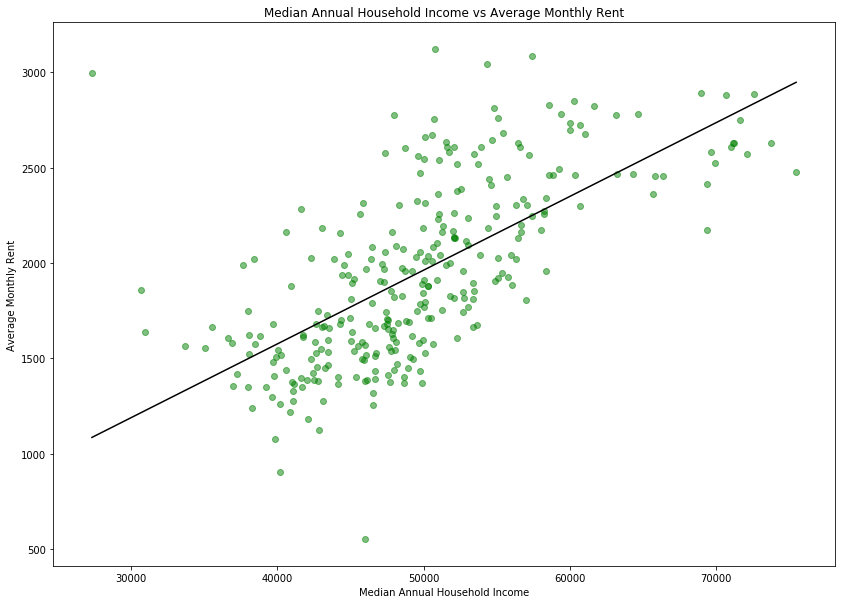

LinregressResult(slope=0.03863685760648959, intercept=29.981492813995374, rvalue=0.661919032565265, pvalue=4.599280156761507e-39, stderr=0.00253883218847698)

Linear correlation coefficient is 0.661919032565265.


In [55]:
result_params = linregress(income_rent[:,0], income_rent[:,1]) #nparray[:,i] will contain all the i'th values from each row.
X_plot = np.linspace(np.amin(income_rent[:,0]),np.amax(income_rent[:,0]),300) #Range of line will be min to max of x values
plt.plot(X_plot, X_plot*result_params[0] + result_params[1], c = 'k') #Plotting line using linregress slope and intercept

plt.scatter(income_rent[:,0], income_rent[:,1], c='g', alpha=0.5) #Plotting as scatter plot:
plt.title('Median Annual Household Income vs Average Monthly Rent')
plt.xlabel('Median Annual Household Income')
plt.ylabel('Average Monthly Rent')
plt.rcParams["figure.figsize"] = 14,10 #Setting size of plot.
plt.show()

#lineregress results -
#slope : slope of the regression line
#intercept : intercept of the regression line
#r-value : correlation coefficient
#p-value : two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero
#stderr : Standard error of the estimate
print(result_params)
print("\nLinear correlation coefficient is %s" %result_params[2] + '.')

##### 3.3: Median annual household income vs walkability score.

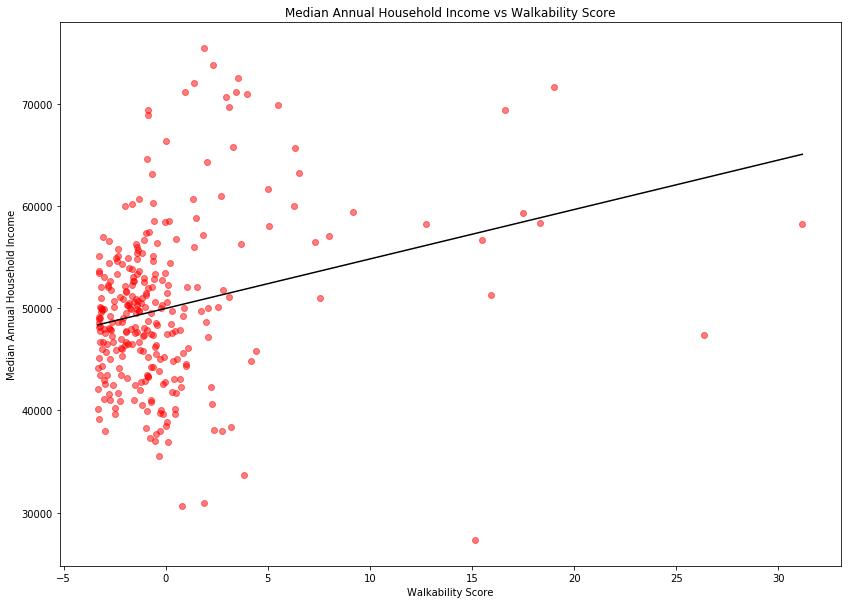

LinregressResult(slope=484.1044553713608, intercept=49991.77176516085, rvalue=0.261760065933471, pvalue=6.743405342377088e-06, stderr=105.54552579019561)

Linear correlation coefficient is 0.261760065933471.


In [54]:
result_params = linregress(w_income[:,0], w_income[:,1])
X_plot = np.linspace(np.amin(w_income[:,0]),np.amax(w_income[:,0]),300)
plt.plot(X_plot, X_plot*result_params[0] + result_params[1], c = 'k')

plt.scatter(w_income[:,0], w_income[:,1], c='r', alpha=0.5)
plt.title('Median Annual Household Income vs Walkability Score')
plt.xlabel('Walkability Score')
plt.ylabel('Median Annual Household Income')
plt.rcParams["figure.figsize"] = 14,10
plt.show()

print(result_params)
print("\nLinear correlation coefficient is %s" %result_params[2] + '.')

##### 3.4: Average monthly rent vs walkability score.

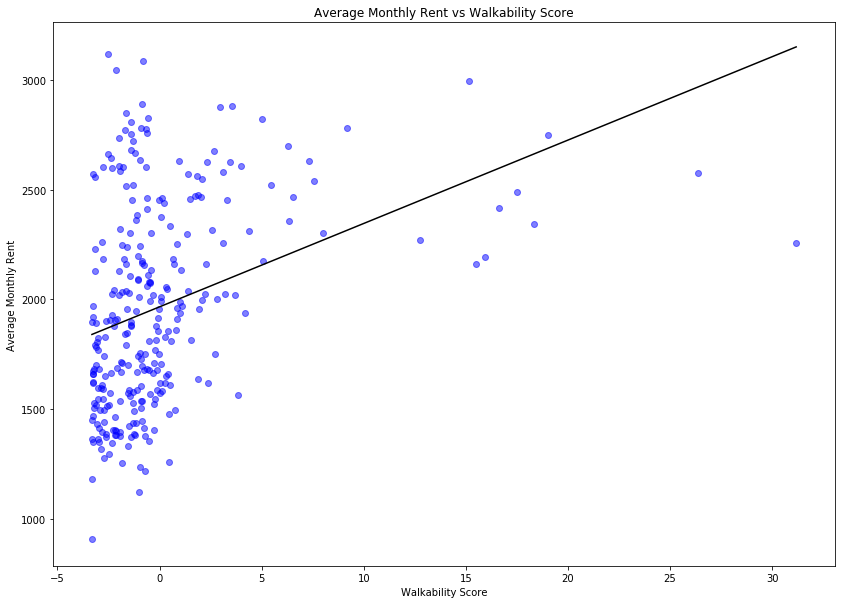

LinregressResult(slope=38.01920006157055, intercept=1966.2963154471622, rvalue=0.3567875463558903, pvalue=4.5191723649376795e-10, stderr=5.886313898691863)

Linear correlation coefficient is 0.3567875463558903.


In [36]:
result_params = linregress(w_rent[:,0], w_rent[:,1])
X_plot = np.linspace(np.amin(w_rent[:,0]),np.amax(w_rent[:,0]),300)
plt.plot(X_plot, X_plot*result_params[0] + result_params[1], c = 'k')

plt.scatter(w_rent[:,0], w_rent[:,1], c='b', alpha=0.5)
plt.title('Average Monthly Rent vs Walkability Score')
plt.xlabel('Walkability Score')
plt.ylabel('Average Monthly Rent')
plt.rcParams["figure.figsize"] = 14,10
plt.show()

print(result_params)
print("\nLinear correlation coefficient is %s" %result_params[2] + '.')

##### 3.5: Create a heatmap of Walkability Scores.

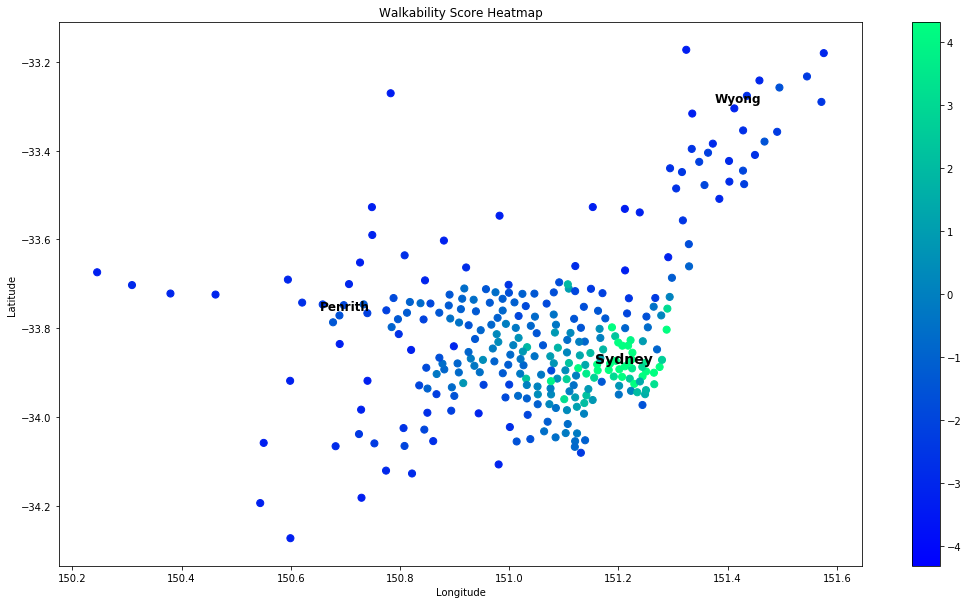

In [52]:
import matplotlib.colors
#A reference point for out heatmap. -33.8688, 151.20933 is the City of Sydney.
ref_point_sydney = -33.8688, 151.20933
ref_point_penrith = -33.7500, 150.7000
ref_point_wyong = -33.2820, 151.4180

#http://stat.abs.gov.au/itt/r.jsp?ABSMaps
#We approximate each SA2 boundary with a point. 
#We choose the centroid if it lies within the boundary, otherwise we take an arbitrary point on the surface.
query_stmt = """SELECT 
                    CASE WHEN (ST_Within(ST_Centroid(boundaries::geometry), boundaries::geometry))
                    THEN ST_X(ST_Centroid(boundaries::geometry))
                    ELSE ST_X(ST_PointOnSurface(boundaries::geometry))
                    END,
                    CASE WHEN (ST_Within(ST_Centroid(boundaries::geometry), boundaries::geometry))
                    THEN ST_Y(ST_Centroid(boundaries::geometry))
                    ELSE ST_Y(ST_PointOnSurface(boundaries::geometry))
                    END,
                    walkability_score
                FROM neighbourhoods NATURAL JOIN walkability;
                """
 
#Contains the latitude/longitude of our approximation point and w scores for each area_id:
lat_long_w = np.array(pgquery(conn, query_stmt, None))

cmap = plt.cm.winter #https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html - for choices of spectrum
w_std = np.std(lat_long_w[:,2]) #Finding std and mean of w scores to spread the colour distribution appropriately across data.
w_mean = np.mean(lat_long_w[:,2])
norm = matplotlib.colors.Normalize(vmin=w_mean-w_std, vmax=w_mean+w_std) 

#Scatter plot of approximate points, choosing colours based on corresponding w score:
plt.scatter(lat_long_w[:,0],lat_long_w[:,1], c=cmap(norm(lat_long_w[:,2])), alpha=1, s=50)
plt.title('Walkability Score Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.rcParams["figure.figsize"] = 18,10 #Increasing size of plot.

#Plotting the referance points:
plt.text(ref_point_sydney[1], ref_point_sydney[0], 'Sydney',size = 14, fontdict=None, withdash=False, 
         verticalalignment='center', horizontalalignment='center', weight='bold')
plt.text(ref_point_penrith[1], ref_point_penrith[0], 'Penrith',size = 12, fontdict=None, withdash=False, 
         verticalalignment='center', horizontalalignment='center', weight='bold')
plt.text(ref_point_wyong[1], ref_point_wyong[0], 'Wyong',size = 12, fontdict=None, withdash=False, 
         verticalalignment='center', horizontalalignment='center', weight='bold')

#Including visual bar to display colour spectrum:
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
sm.set_array([])
plt.colorbar(sm)
plt.show()

##### 3.6: Distance from Sydney vs Walkability Score (Correlation)

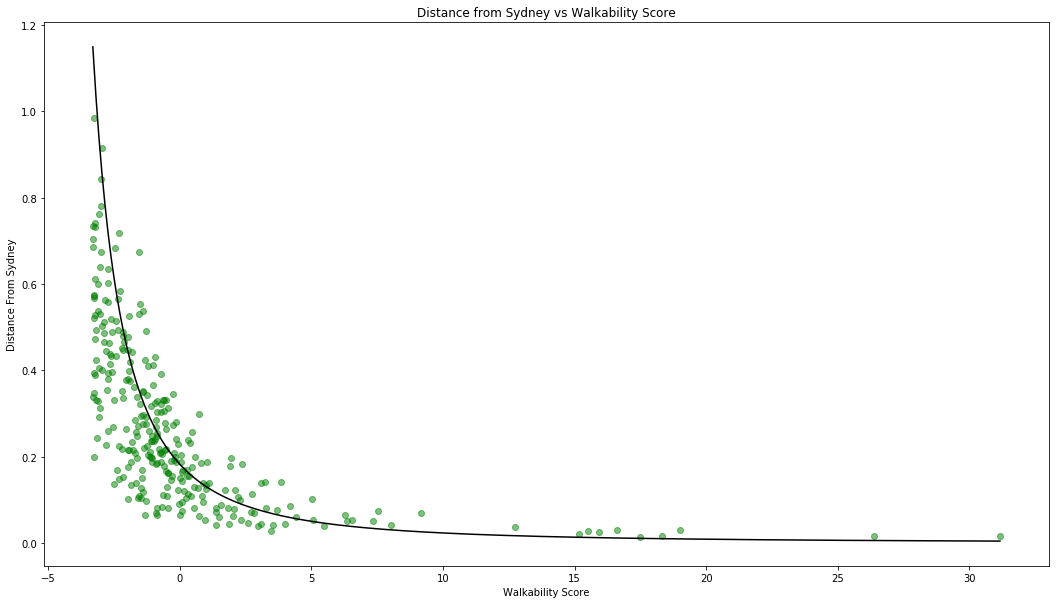


Correlation coefficient is 0.8530465816227951.


In [38]:
#FINDING DISTANCE BETWEEN FIXED POINT AND ARRAY OF POINTS
def distance(fixed_point, array_points):
    return np.sqrt(np.square(fixed_point[1] - array_points[:,0]) + np.square(fixed_point[0] - array_points[:,1]))

#FINDING DISTANCE BETWEEN APPROXIMATE POINTS AND SYDNEY
sydney_distance = distance(ref_point_sydney, lat_long_w[:,:2])

#Choosing approximate inverse square function y = 5.5/(x^2 + 5.5).
result_params = linregress(lat_long_w[:,2], np.sqrt(5.5/sydney_distance - 5.5))
#Applying function inverse to the scatter plot walkability values and finding linear correlation.
X_plot = np.linspace(np.amin(lat_long_w[:,2]),np.amax(lat_long_w[:,2]),300)
plt.plot(X_plot, 5.5/np.square(X_plot+5.5), c = 'k')

plt.scatter(lat_long_w[:,2], sydney_distance, c='g', alpha=0.5)
plt.title('Distance from Sydney vs Walkability Score')
plt.xlabel('Walkability Score')
plt.ylabel('Distance From Sydney')
plt.rcParams["figure.figsize"] = 14,10
plt.show()

print("\nCorrelation coefficient is %s" %result_params[2] + '.')